In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn import preprocessing, metrics
import tensorflow as tf
import tensorflow.contrib.learn as skflow
rcParams['figure.figsize'] = 12, 8

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv').sample(frac=1)
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [5]:
features = df.columns[df.dtypes == np.float64]
target = ' shares'

X = preprocessing.MinMaxScaler().fit_transform(df[features])
Y = np.log(df[target])

N = X.shape[0]

split = np.round(np.array([0.7, 0.85]) * N).astype(np.int)
X_t, X_cv, X_test = np.array_split(X, split)
Y_t, Y_cv, Y_test = np.array_split(Y.reshape(-1, 1), split)

In [43]:
def modelme(nu_hidden):
    def exp_decay(global_step):
        return tf.train.exponential_decay(
            learning_rate=0.01, 
            global_step=global_step,
            decay_steps=10000, 
            decay_rate=0.6
        )

    def model(X, y):
        l3 = skflow.ops.dnn(
            X, 
            hidden_units=[nu_hidden],
            activation=tf.nn.relu6
        )
        return skflow.models.linear_regression(l3, y)

    regressor = skflow.TensorFlowEstimator(
        model_fn=model,
        n_classes=0,
        steps=50000, 
        learning_rate=exp_decay,
        batch_size=128,
        verbose=0
    )
    
    return regressor

for i in range(1,6):
    regressor = modelme(i)
    regressor.fit(X_t, Y_t)
    score = metrics.mean_squared_error(regressor.predict(X_cv), Y_cv)
    print ("%d: " % i, score, score**0.5)


1:  0.87074243765 0.933135808792
2:  0.871232035082 0.933398111784
3:  0.803965901135 0.896641456288
4:  0.808155866421 0.898974897548
5:  0.810443505438 0.900246358192


In [45]:
#10^1:  0.784836568442 0.885910022769 0.798205161176 0.893423282199
#10^2:  0.751519099574 0.866902012672 0.777108769137 0.881537729843
#10^3:  0.71980840028  0.848415228694 0.768454444438 0.876615334361

for i in range(1,6):
    regressor = modelme(10**i)
    regressor.fit(X_t, Y_t)
    score_t = metrics.mean_squared_error(regressor.predict(X_t), Y_t)
    score_cv = metrics.mean_squared_error(regressor.predict(X_cv), Y_cv)
    print ("10^%d: " % i, score_t, score_t**0.5, score_cv, score_cv**0.5)

10^1:  0.784836568442 0.885910022769 0.798205161176 0.893423282199
10^2:  0.751519099574 0.866902012672 0.777108769137 0.881537729843
10^3:  0.71980840028 0.848415228694 0.768454444438 0.876615334361


KeyboardInterrupt: 

In [63]:
def modelme2(nu_hidden):
    def exp_decay(global_step):
        return tf.train.exponential_decay(
            learning_rate=0.01, 
            global_step=global_step,
            decay_steps=10000, 
            decay_rate=0.6
        )

    def model(X, y):
        l3 = skflow.ops.dnn(
            X, 
            hidden_units=nu_hidden,
            activation=tf.nn.relu6
        )
        return skflow.models.linear_regression(l3, y)

    regressor = skflow.TensorFlowEstimator(
        model_fn=model,
        n_classes=0,
        steps=20000, 
        learning_rate=exp_decay,
        batch_size=64,
        verbose=0
    )
    
    return regressor

tf.Session()
import itertools
for sizes in itertools.product([1,10,100,1000], [1,10,100,1000],[1,10]):
    sizes = list(sizes)
    while 1 in sizes:
        sizes.remove(1)
    print("model: ", sizes)
    regressor = modelme2(sizes)
    regressor.fit(X_t, Y_t, logdir='/tmp/ff')
    score_t = 0.5 * metrics.mean_squared_error(regressor.predict(X_t), Y_t)
    score_cv = 0.5 * metrics.mean_squared_error(regressor.predict(X_cv), Y_cv)
    print ("%15.10f %15.10f" % (score_t, score_cv))

model:  []
   0.4482758755    0.4518291812
model:  [10]
   0.3971847409    0.4026943137
model:  [10]
   0.3971847409    0.4026943137
model:  [10, 10]
   0.3868037638    0.3925365933
model:  [100]
   0.3820484431    0.3925466431
model:  [100, 10]
   0.3827785679    0.3910765742
model:  [1000]
   0.3678971274    0.3871911958
model:  [1000, 10]
   0.3681723901    0.3859875239
model:  [10]
   0.3971847409    0.4026943137
model:  [10, 10]
   0.3868037638    0.3925365933
model:  [10, 10]
   0.3868037638    0.3925365933
model:  [10, 10, 10]
   0.3880863385    0.3930506721
model:  [10, 100]
   0.3866375063    0.3939397231
model:  [10, 100, 10]
   0.3858724343    0.3901194148
model:  [10, 1000]
   0.3812157007    0.3916913724
model:  [10, 1000, 10]
   0.3818480472    0.3874065291
model:  [100]
   0.3820484431    0.3925466431
model:  [100, 10]
   0.3827785679    0.3910765742
model:  [100, 10]
   0.3827785679    0.3910765742
model:  [100, 10, 10]
   0.3832665871    0.3902573945
model:  [100, 100]

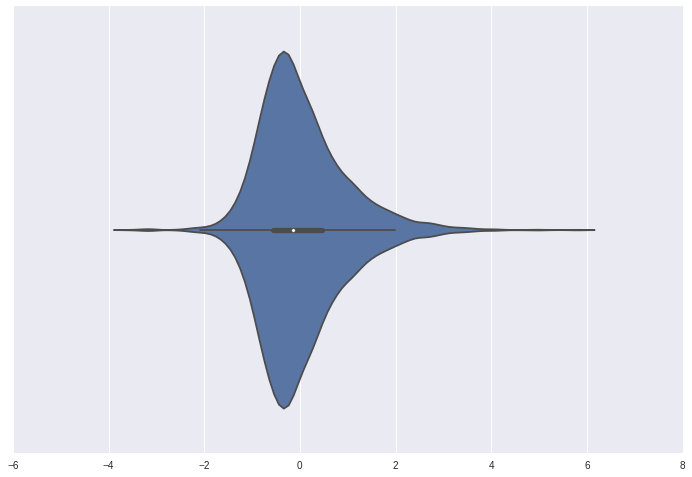

In [39]:
sns.violinplot(Y_cv - regressor.predict(X_cv))